<a href="https://colab.research.google.com/github/Oscar19922017/SeriesTiempo/blob/main/Series_de_Tiempo_con_MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Skforecast: forecasting series temporales con Python y Scikit-learn**

Una serie temporal (time series) es una sucesión de datos ordenados cronológicamente, espaciados a intervalos iguales o desiguales. El proceso de forecasting consiste en predecir el valor futuro de una serie temporal, bien modelando la serie únicamente en función de su comportamiento pasado (autorregresivo) o empleando otras variables externas


<img src="https://www.cienciadedatos.net/images/forecasting_multi-step.gif
" width=800 align="right">


# **Entrenamiento de un modelo de forecasting**

La principal adaptación que se necesita hacer para aplicar modelos de machine learning a problemas de forecasting es transformar la serie temporal en un matriz en la que, cada valor, está asociado a la ventana temporal (lags) que le precede


<img src="https://www.cienciadedatos.net/images/transform_timeseries.gif
" width=800 align="right">

Este tipo de transformación también permite incluir variables exógenas a la serie temporal.

<img src="https://www.cienciadedatos.net/images/matrix_transformation_with_exog_variable.png
" width=800 align="right">

# **Predicciones multi-step**

Cuando se trabaja con series temporales, raramente se quiere predecir solo el siguiente elemento de la serie ( 𝑡+1 ), sino todo un intervalo futuro o un punto alejado en el tiempo ( 𝑡+𝑛 ). A cada paso de predicción se le conoce como step. Existen varias estrategias que permiten generar este tipo de predicciones múltiples.

## **Recursive multi-step forecasting**

Dado que, para predecir el momento  𝑡𝑛  se necesita el valor de  𝑡𝑛−1 , y  𝑡𝑛−1  se desconoce, se sigue un proceso recursivo en el que, cada nueva predicción, hace uso de la predicción anterior. A este proceso se le conoce como recursive forecasting o recursive multi-step forecasting y pueden generarse fácilmente con las clases ForecasterAutoreg y ForecasterAutoregCustom de la librería skforecast.



<img src="https://www.cienciadedatos.net/images/diagrama-multistep-recursiva.png" width=800 align="right">

# **Direct multi-step forecasting**

El método direct multi-step forecasting consiste en entrenar un modelo distinto para cada step. Por ejemplo, si se quieren predecir los siguientes 5 valores de una serie temporal, se entrenan 5 modelos distintos, uno para cada step. Como resultado, las predicciones son independientes unas de otras.


<img src="https://www.cienciadedatos.net/images/diagrama-prediccion-multistep-directa.png" width=800 align="right">

La principal complejidad de esta aproximación consiste en generar correctamente las matrices de entrenamiento para cada modelo. Todo este proceso está automatizado en la clase ForecasterAutoregMultiOutput de la librería skforecast. También es importante tener en cuenta que esta estrategia tiene un coste computacional más elevado ya que requiere entrenar múltiples modelos.

## **Multiple output forecasting**


Determinados modelos, por ejemplo, las redes neuronales LSTM, son capaces de predecir de forma simultánea varios valores de una secuencia (one-shot). Esta estrategia no está disponible en skforecast.

# **Forecasting autorregresivo recursivo**

## **Datos**

Se dispone de una serie temporal con el gasto mensual (millones de dólares) en fármacos con corticoides que tuvo el sistema de salud Australiano entre 1991 y 2008. Se pretende crear un modelo autoregresivo capaz de predecir el futuro gasto mensual.

In [242]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [243]:
#!pip install skforecast

In [244]:
url="https://raw.githubusercontent.com/Oscar19922017/SeriesTiempo/main/St_Ml.csv"

In [245]:
datos = pd.read_csv(url, sep=',')

In [246]:
datos.shape

(195, 4)

In [247]:
195/12

16.25

In [248]:
datos.head()

,fecha,y,exog_1,exog_2
0,1992-04-01,0.379808,0.958792,1.166029
1,1992-05-01,0.361801,0.951993,1.117859
2,1992-06-01,0.410534,0.952955,1.067942
3,1992-07-01,0.483389,0.958078,1.097376
4,1992-08-01,0.475463,0.956370,1.122199


In [249]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fecha   195 non-null    object 
 1   y       195 non-null    float64
 2   exog_1  195 non-null    float64
 3   exog_2  195 non-null    float64
dtypes: float64(3), object(1)
memory usage: 6.2+ KB


In [250]:
datos["fecha"]=pd.to_datetime(datos['fecha'], format='%Y/%m/%d')

In [251]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   195 non-null    datetime64[ns]
 1   y       195 non-null    float64       
 2   exog_1  195 non-null    float64       
 3   exog_2  195 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 6.2 KB


In [252]:
## Indexar Fechas
datos = datos.set_index('fecha')

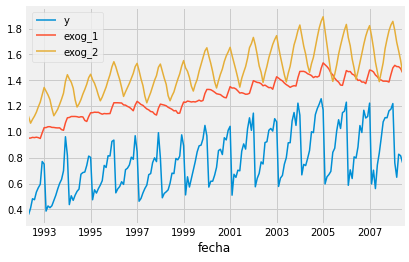

In [253]:
datos.plot()

In [254]:
datos.columns

Index(['y', 'exog_1', 'exog_2'], dtype='object')

In [255]:
datos = datos.rename(columns={'x': 'y'})

In [256]:
datos

,y,exog_1,exog_2
fecha,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199
...,...,...,...
2008-02-01,0.761822,1.515840,1.786373
2008-03-01,0.649435,1.506258,1.694264
2008-04-01,0.827887,1.505253,1.627135


In [257]:
datos = datos.asfreq('MS')

In [258]:
datos

,y,exog_1,exog_2
fecha,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199
...,...,...,...
2008-02-01,0.761822,1.515840,1.786373
2008-03-01,0.649435,1.506258,1.694264
2008-04-01,0.827887,1.505253,1.627135


In [259]:
datos.isnull().sum()

y         0
exog_1    0
exog_2    0
dtype: int64

## **Train y Test**

* Probar el modelo con 36 datos

In [260]:
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

In [261]:
datos_test.shape

(36, 3)

In [262]:
datos_train.shape

(159, 3)

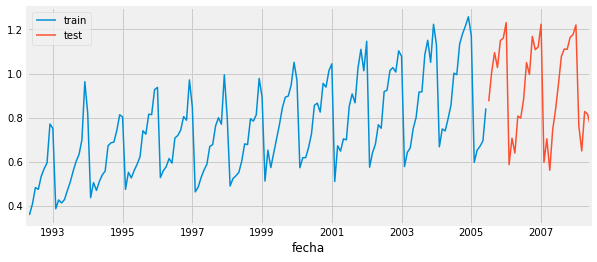

In [263]:
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();

## **Modelo ForecasterAutoreg sin Exogenas**

In [264]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

In [265]:
forecaster.fit(y=datos_train["y"])

In [266]:
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-06-16 01:43:41 
Last fit date: 2022-06-16 01:43:42 
Skforecast version: 0.4.3 

**Eror Predicción**

In [267]:
steps=36
predicciones=forecaster.predict(steps=steps)

In [268]:
predicciones.head(2)

2005-07-01    0.878756
2005-08-01    0.882167
Freq: MS, Name: pred, dtype: float64

**Graficas**

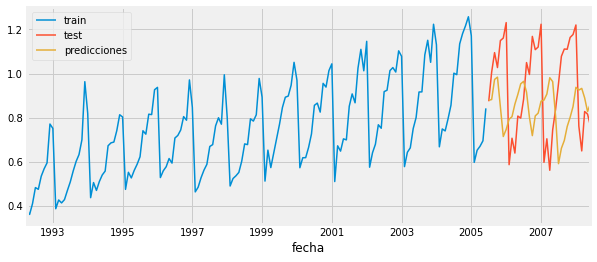

In [269]:
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [270]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

from sklearn.metrics import mean_absolute_error as MAE

def rmse (actual, pred):
    actual, pred = np.array (actual), np.array (pred)
    return np.sqrt (np.square (np.subtract (actual, pred)). mean ())

In [271]:
Actual=datos_test['y']
Prediccion=predicciones
MapeTest=MAPE(Actual,Prediccion)
print(MapeTest)
RMSETest=rmse(Actual,Prediccion)
print(RMSETest)
MaeTest=MAE(Actual,Prediccion)
print(MaeTest)

25.20821273957364
0.2706812512184834
0.2332279091694446


## **Optimización De hiperparametros**

El ForecasterAutoreg entrenado ha utilizado una ventana temporal de 6 lags y un modelo Random Forest con los hiperparámetros por defecto. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados. Para identificar la mejor combinación de lags e hiperparámetros, la librería Skforecast dispone de la función grid_search_forecaster con la que comparar los resultados obtenidos con cada configuración del modelo.

In [272]:
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6 # Este valor será remplazado en el grid search
             )

lags_grid = [6, 20]
## Parametros para RandomForest
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:44<00:00, 22.30s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.012836389345193383



## **Modelo Optimizado**

In [273]:
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=datos_train['y'])

**Evaluar Modelo**

In [274]:
predicciones = forecaster.predict(steps=steps)

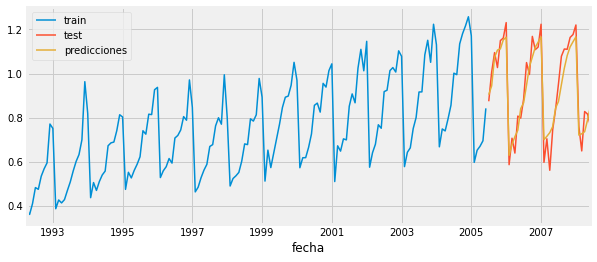

In [275]:
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [276]:
Actual=datos_test['y']
Prediccion=predicciones
MapeTest1=MAPE(Actual,Prediccion)
print(MapeTest1)
RMSETest1=rmse(Actual,Prediccion)
print(RMSETest1)
MaeTest1=MAE(Actual,Prediccion)
print(MaeTest1)

6.453086887142509
0.06627744461849591
0.05496925831555743


## **2) Forecasting autorregresivo recursivo con variables exógenas**

In [277]:
datos

,y,exog_1,exog_2
fecha,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199
...,...,...,...
2008-02-01,0.761822,1.515840,1.786373
2008-03-01,0.649435,1.506258,1.694264
2008-04-01,0.827887,1.505253,1.627135


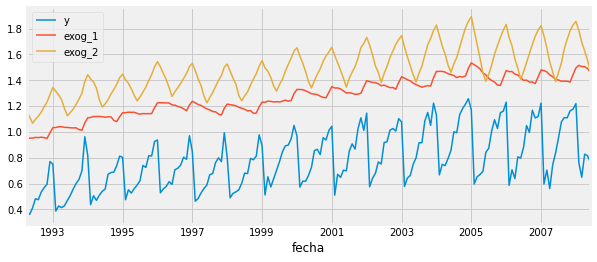

In [278]:
fig, ax = plt.subplots(figsize=(9, 4))
datos['y'].plot(ax=ax, label='y')
datos[['exog_1',"exog_2"]].plot(ax=ax, label='variable exógena')
ax.legend();

In [279]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )

forecaster.fit(y=datos_train['y'], exog=datos_train[['exog_1',"exog_2"]])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Window size: 8 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['exog_1', 'exog_2'] 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-06-16 01:44:31 
Last fit date: 2022-06-16 01:44:32 
Skforecast version: 0.4.3 

In [280]:
predicciones = forecaster.predict(steps=steps, exog=datos_train[['exog_1',"exog_2"]])
predicciones.head(2)

2005-07-01    0.703295
2005-08-01    0.601750
Freq: MS, Name: pred, dtype: float64

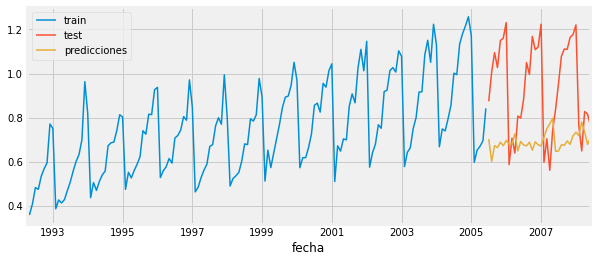

In [281]:
fig, ax=plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();


In [282]:
Actual=datos_test['y']
Prediccion=predicciones
MapeTest2=MAPE(Actual,Prediccion)
print(MapeTest2)
RMSETest2=rmse(Actual,Prediccion)
print(RMSETest2)
MaeTest2=MAE(Actual,Prediccion)
print(MaeTest2)

27.81364244460567
0.33144934937988857
0.2829376904305554


**Random forest 2 Exogenas Optimización**

In [ ]:
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

lags_grid = [5, 12, 20]

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        exog               = datos_train[['exog_1',"exog_2"]],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                    )

Number of models compared: 27


loop param_grid:  22%|████████▍                             | 2/9 [00:02<00:07,  1.07s/it]

In [ ]:
predicciones = forecaster.predict(steps=steps, exog=datos_test[['exog_1',"exog_2"]])

# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
Actual=datos_test['y']
Prediccion=predicciones
MapeTest3=MAPE(Actual,Prediccion)
print(MapeTest3)
RMSETest3=rmse(Actual,Prediccion)
print(RMSETest3)
MaeTest3=MAE(Actual,Prediccion)
print(MaeTest3)

## **XGBoost**

XGBoost, acrónimo de Extreme Gradient Boosting es una implementación muy eficiente del algoritmo de stochastic gradient boosting que se ha convertido en un referente dentro del ámbito de machine learning. Además de su propia API, la librería XGBoost incluye la clase XGBRegressor que sigue la API de scikit learn y, por lo tanto, es compatible con skforecast.

In [ ]:
from xgboost import XGBRegressor

In [ ]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
             )

forecaster.fit(y=datos_train['y'], exog=datos_train[['exog_1',"exog_2"]])
forecaster

In [ ]:
predicciones = forecaster.predict(steps=steps, exog=datos_test[['exog_1',"exog_2"]])

# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
Actual=datos_test['y']
Prediccion=predicciones
MapeTest4=MAPE(Actual,Prediccion)
print(MapeTest4)
RMSETest4=rmse(Actual,Prediccion)
print(RMSETest4)
MaeTest4=MAE(Actual,Prediccion)
print(MaeTest4)

## **XGB Optimo**

In [ ]:
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
             )

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]


resultados_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = datos_train['y'],
        exog               = datos_train[['exog_1',"exog_2"]],
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 36,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(datos_train)*0.5), 
        return_best        = True,
        verbose            = False
)


In [ ]:
predicciones = forecaster.predict(steps=steps, exog=datos_test[['exog_1',"exog_2"]])

# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
Actual=datos_test['y']
Prediccion=predicciones
MapeTest5=MAPE(Actual,Prediccion)
print(MapeTest5)
RMSETest5=rmse(Actual,Prediccion)
print(RMSETest5)
MaeTest5=MAE(Actual,Prediccion)
print(MaeTest5)

## **Modelos Parametricos**

**Sarimax**

In [ ]:
import itertools
import statsmodels.api as sm 
from pylab import rcParams

In [ ]:
y_train=datos_train["y"]
X_train=datos_train["exog_2"]

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

p1=[]
p2=[]
p3=[]


for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,order=param,seasonal_order=param_seasonal,enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            #print("ARIMA{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            p1.append(param)
            p2.append( param_seasonal)
            p3.append(results.aic)
            
        except:
            continue
df = pd.DataFrame({'param' : p1, 'param_seasonal' :p2,"results.aic":p3})
df[df["results.aic"]==min(p3)]

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=(1, 0, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

In [ ]:
y_train.head(2)

In [ ]:
pred=results.get_prediction(start=pd.to_datetime("1992-04-01"),dynamic=False)

In [ ]:
pred.predicted_mean.plot()
y_train.plot()

**Error Test**

In [ ]:
X_Test=datos_test["exog_2"]
y_test=datos_test["y"]

In [ ]:
Pred_uc=results.get_forecast(steps=36)

In [ ]:
y_test.plot(label="Observado")
Pred_uc.predicted_mean.plot()

In [ ]:
predicciones=Pred_uc.predicted_mean

In [ ]:
fig, ax=plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
Actual=datos_test['y']
Prediccion=predicciones
MapeTest6=MAPE(Actual,Prediccion)
print(MapeTest6)
RMSETest6=rmse(Actual,Prediccion)
print(RMSETest6)
MaeTest6=MAE(Actual,Prediccion)
print(MaeTest6)

## **Phophet**

FB Prophet es un modelo muy extendido para la predicción de series temporales desarrollado por Facebook. El paquete FB Prophet ha sido desarrollado tanto para R como para Python.El objetivo de este paquete es dar a los usuarios una herramienta potente y de fácil uso para predecir resultados de negocio. Está muy bien documentado en su web, por lo que es fácil aprender a usarlo y de ajustarlo.

In [ ]:
from fbprophet import Prophet

In [ ]:
df=datos_train[["y"]]

In [ ]:
df["ds"]=df.index
df=df.reset_index(drop=True)

In [ ]:
df=df[["ds","y"]]

In [ ]:
df.tail(15)

In [ ]:
m = Prophet()
m.fit(df)

In [ ]:
future = m.make_future_dataframe(periods=34,freq="MS")

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# Python
fig1 = m.plot(forecast)

In [ ]:
# Python
fig2 = m.plot_components(forecast)


In [ ]:
predicciones=forecast[["ds","yhat"]][157:]

In [ ]:
predicciones.index=predicciones.ds

In [ ]:
predicciones=predicciones.yhat

In [ ]:
fig, ax=plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
Actual=datos_test['y']
Prediccion=predicciones
MapeTest7=MAPE(Actual,Prediccion)
print(MapeTest7)
RMSETest7=rmse(Actual,Prediccion)
print(RMSETest7)
MaeTest7=MAE(Actual,Prediccion)
print(MaeTest7)

# **Resultados**

In [ ]:
Resultados= pd.DataFrame({"Modelos":["RF","RF Optimo","RF 2Exo","RF 2exo Opt","XGB","XGB OPT","SARIMAX","Prophe"],
                          "Mape":[MapeTest,MapeTest1,MapeTest2,MapeTest3,MapeTest4,MapeTest4,MapeTest6,MapeTest7],
                          "Mae":[MaeTest,MaeTest1,MaeTest2,MaeTest3,MaeTest4,MaeTest4,MaeTest6,MaeTest7],
                          "RMSE":[RMSETest,RMSETest1,RMSETest2,RMSETest3,RMSETest4,RMSETest4,RMSETest6,RMSETest7
                                  ]})

In [ ]:
Resultados.sort_values("Mape",ascending=True)